# Linear Regression and Kalman Filter

24 June 2017

Reference:
[QuantCon 2016: Using the Kalman Filter in Algorithmic Trading](https://www.quantopian.com/posts/quantcon-2016-using-the-kalman-filter-in-algorithmic-trading)

This work is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm

In [2]:
tickers = ['PEP', 'KO']
data = get_pricing(symbols(tickers), start_date='2006-1-1', end_date='2008-8-1', 
                   fields='close_price', frequency='daily')
data.columns = [ticker.symbol for ticker in data.columns]
data.index.name = 'Date'

In [3]:
data.head()

,PEP,KO
Date,,
2006-01-03 00:00:00+00:00,56.785,38.273
2006-01-04 00:00:00+00:00,56.747,38.208
2006-01-05 00:00:00+00:00,56.424,38.404
2006-01-06 00:00:00+00:00,56.633,38.732
2006-01-09 00:00:00+00:00,56.367,38.938


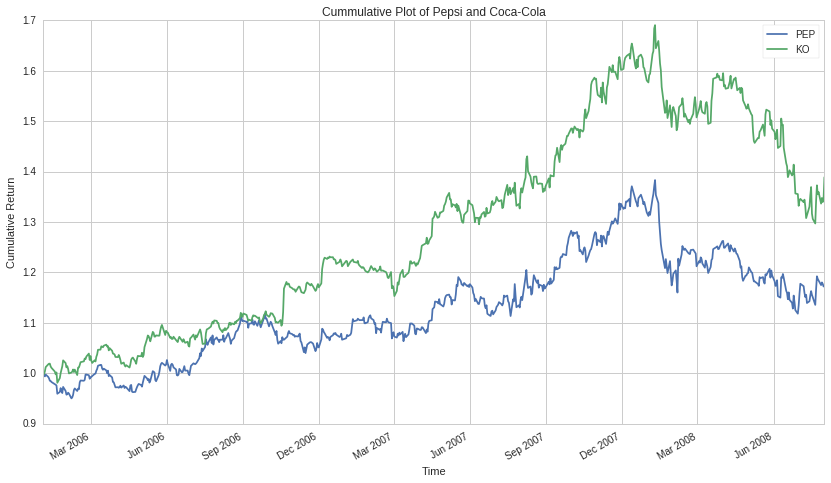

In [4]:
cumm_rtn = (1 + data.pct_change()).cumprod()
cumm_rtn.plot();
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
plt.title('Cummulative Plot of Pepsi and Coca-Cola');

## Visualize Price Relationship Between the Two Securities

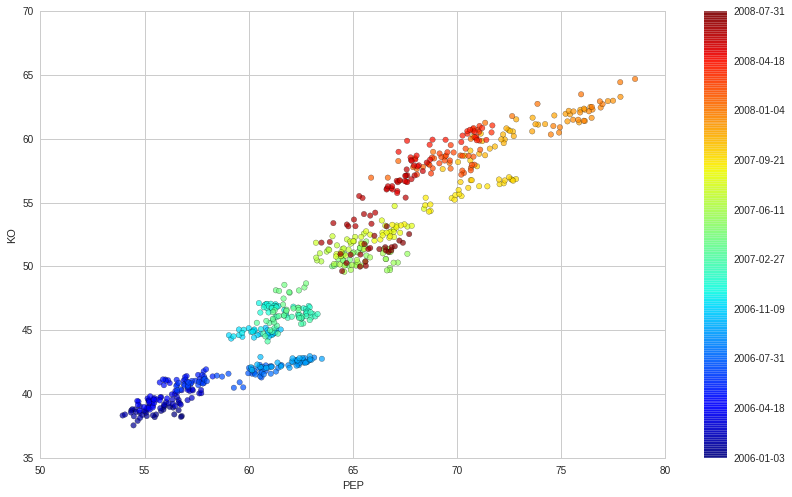

In [5]:
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

***

## Linear Regression

**Linear Regression in vector form**

$$y = \beta x + \varepsilon$$

where,

\begin{equation*}
y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n
\end{pmatrix}
\end{equation*}

\begin{equation*}
x = \begin{pmatrix} x_1^T \\ x_2^T \\ \vdots \\ x_n^T
\end{pmatrix}
\end{equation*}

\begin{equation*}
\beta  = \begin{pmatrix} \beta_0  \\ \beta_1  \\ \vdots \\ \beta_p 
\end{pmatrix}
\end{equation*}

\begin{equation*}
\varepsilon   = \begin{pmatrix} \varepsilon_1  \\ \varepsilon_2  \\ \vdots \\ \varepsilon_n 
\end{pmatrix}
\end{equation*}


**Spread**


$$
\begin{align*}
\varepsilon & = y - \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix} \begin{bmatrix} 1 \\ x \end{bmatrix}  \\ \\
& = p^{KO} - \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix} \begin{bmatrix} 1 \\ p^{PEP} \end{bmatrix} \\ \\
& = p^{KO} - \beta_0 - \beta_1 p^{PEP}
\end{align*}
$$


where,

$p = Price$


### Estimation with Stats Model

Using the statsmodel to estimate the parameters

In this instance, KO is our dependent variable and PEP is out independent variable.

In [6]:
x = sm.add_constant(data[tickers[0]], prepend=False)
ols = sm.OLS(data[tickers[1]], x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [7]:
print(ols.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.919    
Dependent Variable: KO               AIC:                2837.4049
Date:               2017-06-24 09:57 BIC:                2846.3588
No. Observations:   650              Log-Likelihood:     -1416.7  
Df Model:           1                F-statistic:        7355.    
Df Residuals:       648              Prob (F-statistic): 0.00     
R-squared:          0.919            Scale:              4.5919   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
PEP          1.2688    0.0148   85.7605  0.0000    1.2397    1.2978
const      -31.9220    0.9511  -33.5622  0.0000  -33.7896  -30.0543
------------------------------------------------------------------
Omnibus:              8.992         Durbin-Watson:           0.082
Prob(Om

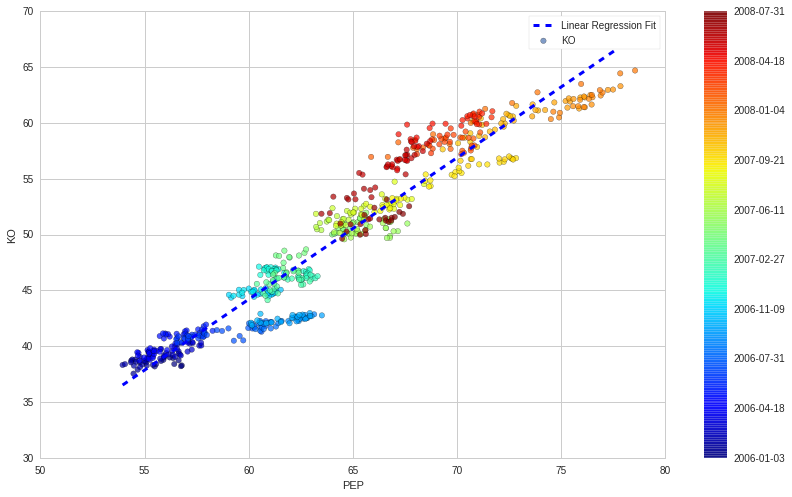

In [8]:
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
plt.legend()

cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

It is a perfect fit because this is in-sample or using the train datasets

### Linear Regression with Scikit-learn

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
reg = LinearRegression(fit_intercept=True)
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
reg.fit(data[tickers[0]].reshape(-1,1), data[tickers[1]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
print("The beta coefficient is {0} and \nThe intercept coefficient is {1}".format(reg.coef_, reg.intercept_))

The beta coefficient is [ 1.26875149] and 
The intercept coefficient is -31.9219750797


### Modelling the Spread

Recall that

$$\varepsilon = \beta x - y $$

In [13]:
spread = pd.DataFrame(data[tickers[1]] - beta[0] * data[tickers[0]] - beta[1])
spread.columns = ['in-sample']

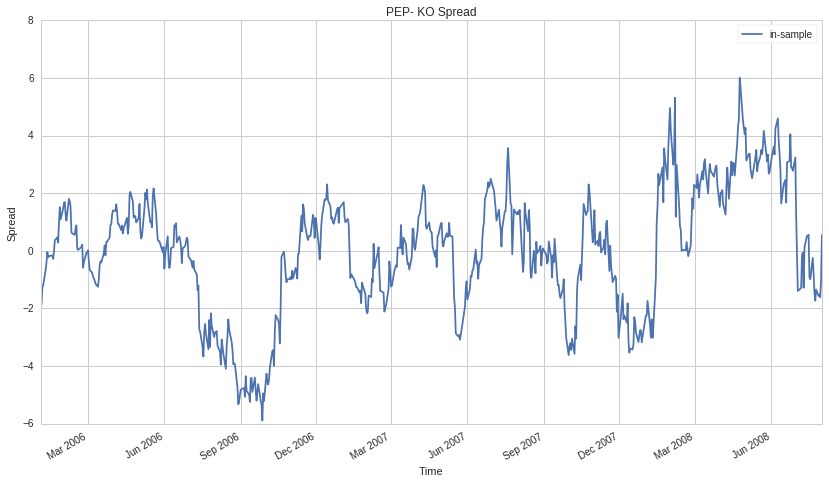

In [14]:
spread.plot();
plt.xlabel('Time');
plt.ylabel('Spread');
plt.title('PEP- KO Spread');

## Testing for Cointegration

In [15]:
adf = statsmodels.tsa.stattools.adfuller(spread['in-sample'], maxlag=1)
print('ADF test statistic: {:.03f}').format(adf[0])
print('p-value: {:.03f}').format(adf[1])

ADF test statistic: -3.411
p-value: 0.011


### Trading logic

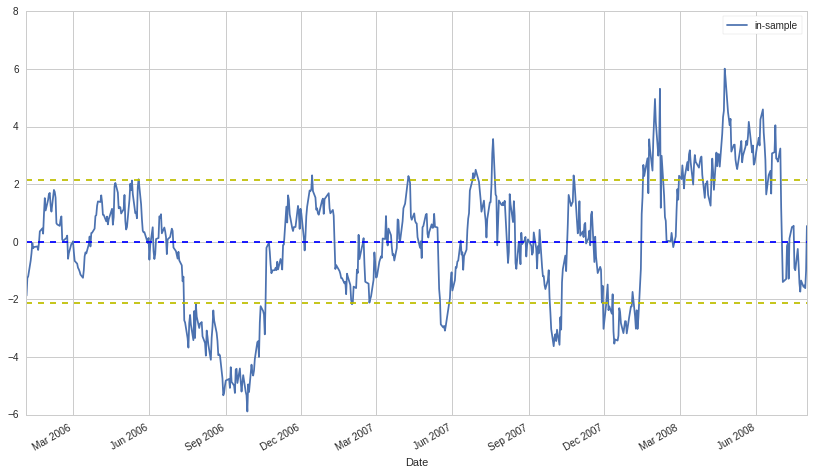

In [16]:
spread.plot();
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');

### Out of Sample / Test Set

In [17]:
data_oos = get_pricing(symbols(tickers), start_date='2008-8-1', end_date='2010-1-1', 
                       fields='close_price', frequency='daily')
data_oos.columns = [ticker.symbol for ticker in data_oos.columns]
data_oos.index.name = 'Date'

In [18]:
spread_oos = spread.reindex((spread.index).union(data_oos.index))

In [19]:
spread_oos['out-of-sample'] = data_oos[tickers[1]] - beta[0] * data_oos[tickers[0]] - beta[1]

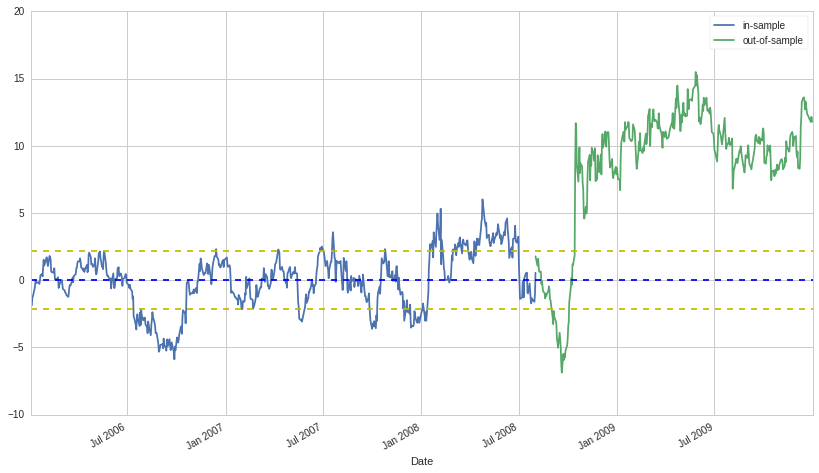

In [20]:
spread_oos.plot();
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');

### What Happened? 

The relationship broke during 2008

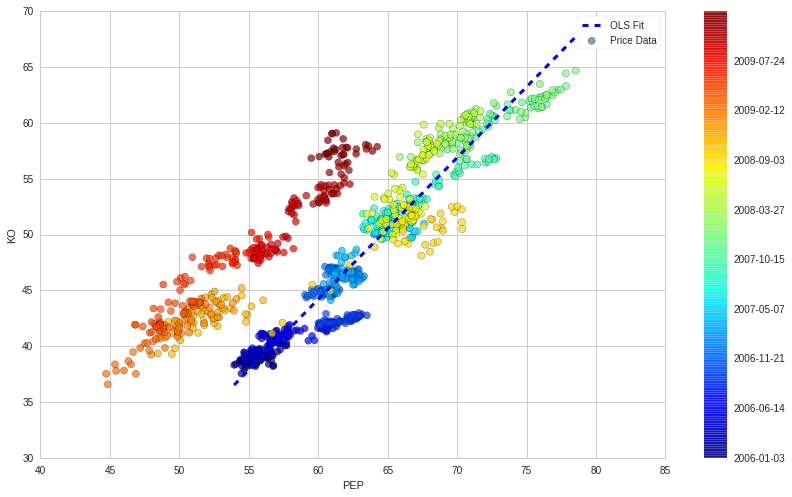

In [21]:
data_all = data.append(data_oos)
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], s=50, c=colors, 
                 cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

***

## Kalman Filter

Great explanation by [Tim Babb](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)

**State Space Model**

* Describe set of hidden state variables, $\theta_t$. **Transition** equation:
    
$$\theta_t = G_t \theta_{t-1} + w_t$$

* **Observation** equation

$$y_t = F_t \theta_t + v_t$$

* $w_t$ and $v_t$ are Guassian white noise

* Recall the linear regression relationship

$$y = \beta x + \varepsilon$$

$$
p^{KO} =  \beta_0 + \beta_1 p^{PEP} + \varepsilon 
$$


Linear Regression in Kalman filter terminologies:

**Hidden State**:
$$\theta_t = \beta_t$$

**Transition Matrix**:
$$G_t = {\bf I}$$

**Observations**:
$$y_t = p^{KO}$$

**Observation matrix**:
$$F_t = \begin{pmatrix} 1 \\ p^{PEP} \end{pmatrix}$$

**Transition** equation

$$\beta_{t+1} ={\bf I} \beta_{t} + w_t$$


**Observation** equation

$$p^{KO} = \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix} \begin{bmatrix} 1 \\ p^{PEP} \end{bmatrix} + v_t$$



In [22]:
obs_mat = sm.add_constant(data_all[tickers[0]].values, prepend=False)[:, np.newaxis]

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))

In [23]:
state_means, state_covs = kf.filter(data_all[tickers[1]])

In [24]:
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]},
                       index=data_all.index)

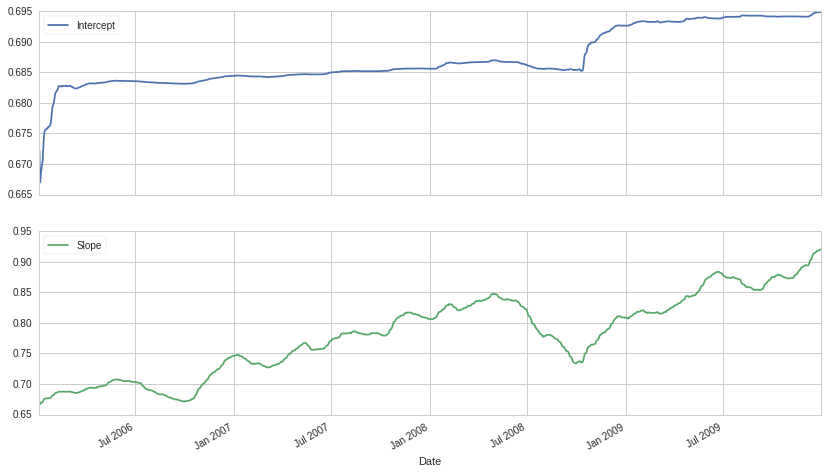

In [25]:
beta_kf.plot(subplots=True);

### Visualising Kalman Filter

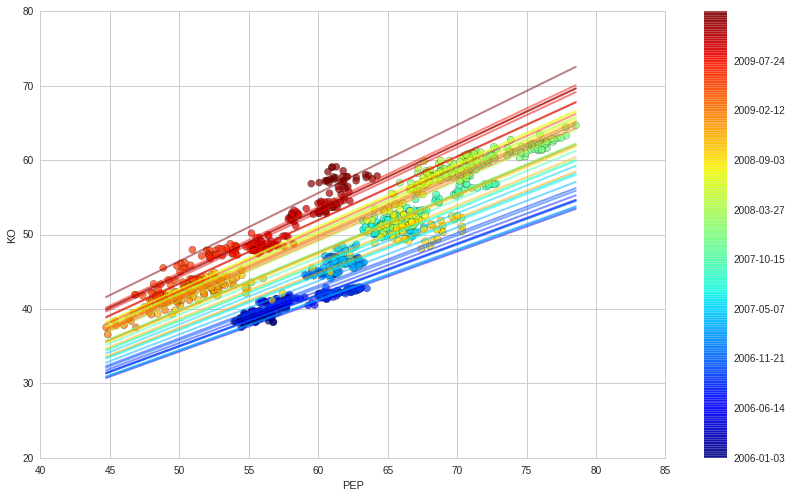

In [26]:
# visualize the correlation between assest prices over time
dates = [str(p.date()) for p in data_all[::len(data_all)/10].index]
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], 
                 s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all)//9].index]);
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])

# add regression lines
step = 25
xi = np.linspace(data_all[tickers[0]].min(), data_all[tickers[0]].max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))

### Modelling PEP - KO Spread with Kalman Filter

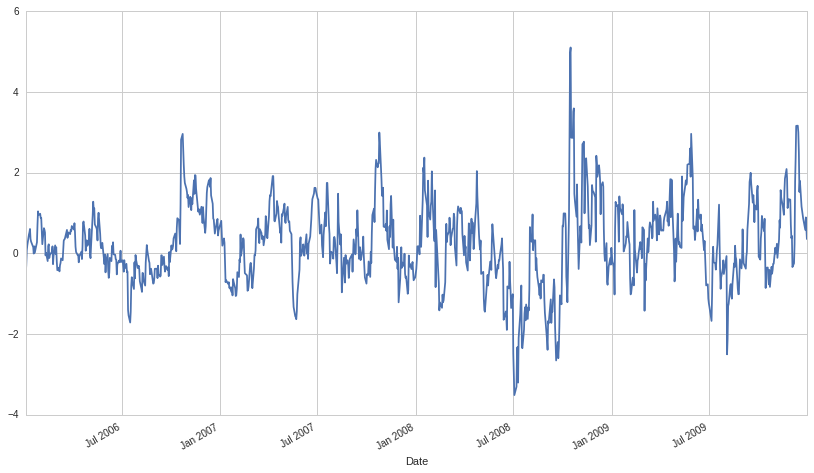

In [27]:
spread_kf = data_all[tickers[1]] - data_all[tickers[0]] * beta_kf['Slope'] - beta_kf['Intercept']
spread_kf.plot();

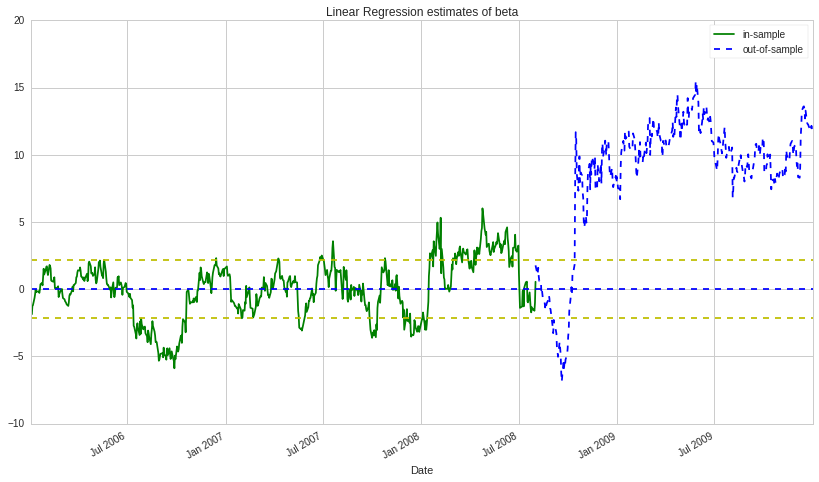

In [28]:
spread_oos.plot(style=['g', '--b', '--y', '--y', 'r']);
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');
plt.legend(loc=0);
plt.title('Linear Regression estimates of beta');

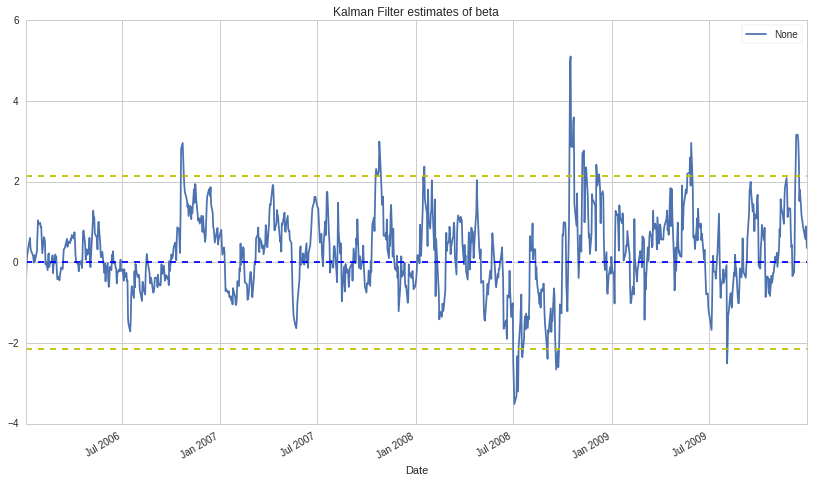

In [29]:
spread_kf.plot()
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');
plt.legend(loc=0);
plt.title('Kalman Filter estimates of beta');

## Further References:

1. Pairs Trading [Wikipedia](https://en.wikipedia.org/wiki/Pairs_trade)
1. O'Mahony, A. (2014). [Online Linear Regression using a Kalman Filter](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)
1. Faragher, R. (2012). Understanding the Basis of the Kalman Filter Via a Simple and Intuitive Derivation [Lecture Notes](http://www.cl.cam.ac.uk/~rmf25/papers/Understanding%20the%20Basis%20of%20the%20Kalman%20Filter.pdf). IEEE Signal Processing Magazine, 29(5), 128-132. doi:10.1109/msp.2012.2203621
1. Halls-Moore, M. (2016). [Dynamic Hedge Ratio Between ETF Pairs Using the Kalman Filter](https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter)
1. Halls-Moore, M. (2014). [Backtesting An Intraday Mean Reversion Pairs Strategy Between SPY And IWM](https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM)
1. How a Kalman filter works, in pictures. [Bzarg](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
1. Kalman Filter. [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter)


***